In [8]:
library(Rsamtools)
library(GenomicRanges)
library(repr) # library to resize the plots 
#install.packages("viridis")
library(viridis) #The viridis color palettes
library(RColorBrewer)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, grep, grepl,
    intersect, is.unsorted, lapply, lengths, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unlist, unsplit

Loading required package: IRanges
Loading required package: GenomeInfoDb
L

In [3]:
file_of_interest.df<- read.csv('/data/genome_feature_files/yeast/genes/sacCer3_ucsc_geneTable.bed',sep= "\t",header=F, stringsAsFactors = F)
#file_of_interest.df <- read.csv("/data/genome_feature_files/yeast/genes/xu_tss_sites_sacCer3.bed", sep="\t", header=F)
colnames(file_of_interest.df) <- c("chr", "start", "end","name", "na", "strand")


In [5]:
##looking at gene expression data.
mRNA_vs_NETseq.df <- read.table("/data/home/mpg22/NET-Seq_data_churchman_weissman/aligned_data/netseq_mRNA_nofooter.htseq",stringsAsFactors = F)
colnames(mRNA_vs_NETseq.df) <- c("gene", "mRNA", "NET-seq")
vt_mrna_seq <- read.table("/data/home/mpg22/feature_files/control_for_monica",stringsAsFactors = F)
colnames(vt_mrna_seq) <- c("gene", "rna_seq")

mRNA_vs_NETseq.df$fpkm_mRNA <- NA
mRNA_vs_NETseq.df$fpkm_NETseq <- NA

###normalizing by gene length
for(g in 1:nrow(mRNA_vs_NETseq.df)){
  name <- mRNA_vs_NETseq.df$gene[g]
  idx = which(file_of_interest.df$name == name)
  if(length(idx) == 0){
    mRNA_vs_NETseq.df$fpkm_mRNA[g] <- 0
    mRNA_vs_NETseq.df$fpkm_NETseq[g] <-0
  }
  else{
    largo <- (file_of_interest.df$end[idx] - file_of_interest.df$start[idx])
    mRNA_vs_NETseq.df$fpkm_mRNA[g] <- mRNA_vs_NETseq.df$mRNA[g]/largo
    mRNA_vs_NETseq.df$fpkm_NETseq[g] <- mRNA_vs_NETseq.df[g,3]/largo
}
}

cn.df$mRNA<- NA
cn.df$NET_seq <- NA



In [6]:
for(w in 1:nrow(cn.df)){
  idx <- which(mRNA_vs_NETseq.df$gene == cn.df$gene[w])
  cn.df$mRNA[w] <- mRNA_vs_NETseq.df[idx,4]
  cn.df$NET_seq[w] <- mRNA_vs_NETseq.df[idx,5]
}


In [7]:
## determine number of H2AZ nucleosomes in each gene. 
#data files for H2AZ enrichment based on the Albert 2007 paper. 
h2az_bed <- read.table("/data/home/mpg22/aug_2015_assembly_experiment/analysis/H2AZ/Albert_2007_H2AZ_nucleosome_positions_V64.bed",header=F)
colnames(h2az_bed) <- c('chr_1','start','end','id','score')

h2az_bed.gr <- GRanges(seqnames=h2az_bed$chr, IRanges(start=h2az_bed$start, end=h2az_bed$end), score=h2az_bed$score, id=h2az_bed$id)
ranges(h2az_bed.gr) = IRanges(start=mid(ranges(h2az_bed.gr)), width=1) 

# based on plotting, longer genes will obviously have more h2az nucleosomes, with the exception of the 6 largest genes . how about just looking first 3 nucleosomes.?

In [8]:
#adding H2Az scores based on +1 nucleosome only. 
#since the numbers are the same for all 3 data sets, it should be ok to use just one as reference to obtain the numbers
#then add it to the other 2. 

for(g in 1:nrow(cn.df)){
    ss <- cn.df[g,]
    
    if(ss$strand == '+'){     
        ss$nuc1_start <- ss$start
        ss$nuc1_end <- ss$start +150
    }
    else{        
        ss$nuc1_start <- ss$end - 150
        ss$nuc1_end <- ss$end
    }
    ss.gr <-  GRanges(seqnames=ss$chr, IRanges(start=ss$nuc1_start, end=ss$nuc1_end), gene=ss$gene)
   
    Ovh2az <- as.data.frame(findOverlaps(h2az_bed.gr,ss.gr))
    
    score <- (h2az_bed$score[Ovh2az[,1]])
   
    if(length(score) >= 1 ){
        cn.df$h2az_1_score[g] <- score
    }
    
    else{
        cn.df$h2az_1_score[g] <- 0 
    }
}


Warning message in cn.df$h2az_1_score[g] <- score:
“number of items to replace is not a multiple of replacement length”Warning message in cn.df$h2az_1_score[g] <- score:
“number of items to replace is not a multiple of replacement length”Warning message in cn.df$h2az_1_score[g] <- score:
“number of items to replace is not a multiple of replacement length”Warning message in cn.df$h2az_1_score[g] <- score:
“number of items to replace is not a multiple of replacement length”

In [54]:
#### directionality, replication fork movement. with gene transcription 
data = vector("list")
data_pos=vector('list')
data_neg=vector('list')

for(r in 1:nrow(cn.df)){
  chr = cn.df[r,"chr"] 
  
        new_start= cn.df[r, "start"]
        new_end= cn.df[r, "end"]  
 
  chr.gr = GRanges(seqnames= chr, ranges = IRanges(start =new_start , end = new_end ))
  
  p = ScanBamParam(what = c("rname", "strand", "pos", "qwidth"),which = chr.gr)

    #data files
    file_name.bam = "/data/home/mpg22/whitehouse_data/DMSRR364781/2017-03-27-13-58/wh_sacCer3.bam"
    file_name.bam.bai = "/data/home/mpg22/whitehouse_data/DMSRR364781/2017-03-27-13-58/wh_sacCer3.bam.bai"
    
A_reads.l = scanBam(file = file_name.bam, 
                        index = file_name.bam.bai,
                        param = p)    

    #All the information from the range is in the first entry of the output_reads.l list (this can be 	accessed by output_reads.l[[1]]).
    # str(output_reads.l[[1]]) to see list structure
    
    #create a new GenomicRanges object for the reads from this list:
    A_reads.gr = GRanges(seqnames = A_reads.l[[1]]$rname,
                         ranges = IRanges(start = A_reads.l[[1]]$pos, 
                                          width = A_reads.l[[1]]$qwidth),
                                          strand = A_reads.l[[1]]$strand)
    
    #subset reads by strand 
    pos.gr <- A_reads.gr[strand(A_reads.gr) == '+']
    neg.gr <- A_reads.gr[strand(A_reads.gr) == '-']
    
    # doing it like this so that numbers with a negative value are for genes transcribed against direction of the fork
    #while genes that are transcribed in the direction of replication have a positive number. 
    w.c <- nrow(as.data.frame(pos.gr))/nrow(as.data.frame(neg.gr)) 
    c.w <- nrow(as.data.frame(neg.gr))/nrow(as.data.frame(pos.gr)) 

  
     if(cn.df$strand[r] == '+'){ 
     cn.df$directionality[r] <-   log2(w.c)
    }
    
    else{
    cn.df$directionality[r] <-   log2(c.w)  
    }
    
    
    cat(paste("saving gene", r,"\n"))
    
    # if(cn.df$strand[r] == '+'){
    #    if(c.w > 1){ # coding strand is the leading strand
     #     cn.df$directionality[r] <- c.w  
       # }
        #else{
         #   cn.df$directionality[r] <- -w.c
        #}
        #}
    
   # else{
    # if(w.c > 1){ # template strand is the leading strand
     #     cn.df$directionality[r] <- w.c
      #  }
       # else{
        #    cn.df$directionality[r] <- -c.w
        #}
        #}
    
    }

saving gene 1 
saving gene 2 
saving gene 3 
saving gene 4 
saving gene 5 
saving gene 6 
saving gene 7 
saving gene 8 
saving gene 9 
saving gene 10 
saving gene 11 
saving gene 12 
saving gene 13 
saving gene 14 
saving gene 15 
saving gene 16 
saving gene 17 
saving gene 18 
saving gene 19 
saving gene 20 
saving gene 21 
saving gene 22 
saving gene 23 
saving gene 24 
saving gene 25 
saving gene 26 
saving gene 27 
saving gene 28 
saving gene 29 
saving gene 30 
saving gene 31 
saving gene 32 
saving gene 33 
saving gene 34 
saving gene 35 
saving gene 36 
saving gene 37 
saving gene 38 
saving gene 39 
saving gene 40 
saving gene 41 
saving gene 42 
saving gene 43 
saving gene 44 
saving gene 45 
saving gene 46 
saving gene 47 
saving gene 48 
saving gene 49 
saving gene 50 
saving gene 51 
saving gene 52 
saving gene 53 
saving gene 54 
saving gene 55 
saving gene 56 
saving gene 57 
saving gene 58 
saving gene 59 
saving gene 60 
saving gene 61 
saving gene 62 
saving gene 63 
s

In [64]:
#write.csv(cn.df, "~/March_2017_chromatin_assembly//Merged_data/final_merged_files/cn_complete_okcorrected.csv")

In [2]:

#cnm.df <- read.csv("/data/home/mpg22/March_2017_chromatin_assembly/Merged_data//final_merged_files/cn_merged.csv", stringsAsFactors = F)
cnm.df <- read.csv("/data/home/mpg22/March_2017_chromatin_assembly/Merged_data/data_frames/cn_complete_okcorrected_ratios.csv", stringsAsFactors = F)


In [3]:
#del1 <- (which(cn17pcr.df$EdU5_30_bulk == 1))
#delete rows with chrM
#cn.df<- cnm.df[-(which(cnm.df$chr == "chrM")),-1]
cn.df<- cnm.df[,-1]

In [6]:
head(cn.df)

EdU5_0_bulk,EdU5_30_bulk,EdU10_0_bulk,EdU10_30_bulk,inputs5_0_30,chr,gene,length,peaks,depth_a,⋯,mid_dist_e,strand,start,end,mRNA,NET_seq,h2az_1_score,directionality,ratio,mid_ratio
0.9135431,0.8273183,0.8876251,0.8155849,0.9971008,chrI,YAL069W,315,2,448,⋯,9.540117,+,334,649,0.000000000,0.000000000,16.958007,4.1085245,-0.12211555,-0.07532292
0.9781685,0.9993220,0.9861984,0.9942133,0.9961717,chrI,YAL068W-A,255,2,358,⋯,5.547945,+,537,792,0.003921569,0.003921569,17.861484,2.8073549,0.01167761,-0.60654936
0.8143767,0.9263432,0.4484318,0.8916972,0.9808242,chrI,YAL068C,363,3,355,⋯,13.027397,-,1806,2169,0.011019284,0.022038567,22.313863,0.7776076,0.99166541,-1.06420963
0.9934882,0.9861784,0.9784249,0.9928258,0.9942989,chrI,YAL067W-A,228,2,230,⋯,9.825832,+,2479,2707,0.004385965,0.017543860,0.000000,0.2895066,0.02107955,0.71109071
0.7224885,0.8319213,0.4346318,0.8342221,0.9330314,chrI,YAL067C,1782,14,1926,⋯,16.164384,-,7234,9016,0.020202020,0.047699214,4.575806,-2.7789731,0.94063786,0.15375568
0.8092933,0.8946042,0.6975887,0.5412692,0.9049782,chrI,YAL066W,309,3,445,⋯,15.761252,+,10090,10399,0.000000000,0.006472492,1.000000,2.2223924,-0.36603042,-0.08953853


ERROR: Error in stripchart.default(cn.df[, 1], cn.df[, 2], cn.df[, 3], cn.df[, : 'names' attribute [6664] must be the same length as the vector [1]


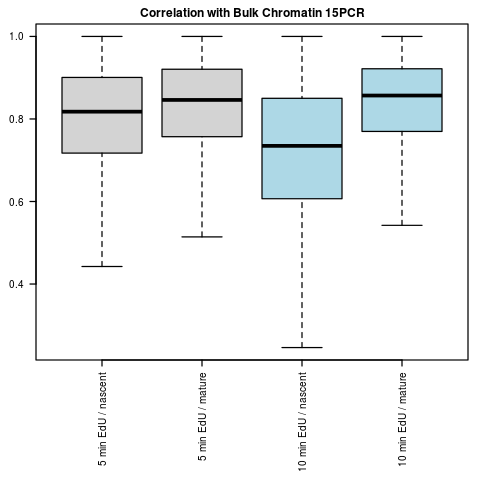

In [72]:
options(repr.plot.width=4, repr.plot.height=4)
par(#mfrow=c(1,3),
    mar=c(10,3,2,1),
   cex=0.5)
colors = c(rep("light gray",2),rep("light blue",2))
boxplot(cn.df[,1],cn.df[,2],cn.df[,3],cn.df[,4],
        las=2,outline=FALSE, col=colors, main="Correlation with Bulk Chromatin 15PCR", 
        names=c("5 min EdU / nascent", "5 min EdU / mature", "10 min EdU / nascent", "10 min EdU / mature"))
stripchart(cn.df[,1],cn.df[,2],cn.df[,3],cn.df[,4], vertical = TRUE, 
    method = "jitter", add = TRUE, pch = 20, col = 'blue')


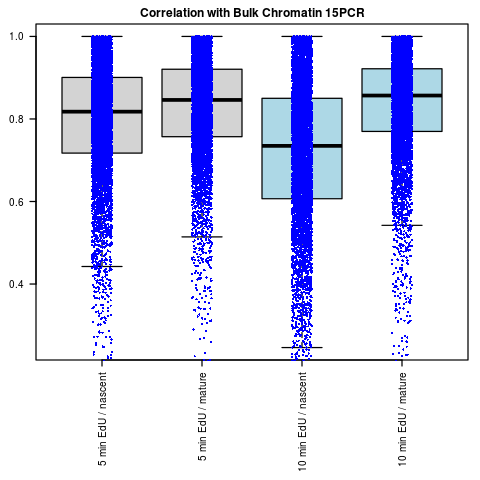

In [79]:
options(repr.plot.width=4, repr.plot.height=4)
par(#mfrow=c(1,3),
    mar=c(10,3,2,1),
   cex=0.5)
colors = c(rep("light gray",2),rep("light blue",2))
boxplot(cn.df[,1:4],
        las=2,outline=FALSE, col=colors, main="Correlation with Bulk Chromatin 15PCR", 
        names=c("5 min EdU / nascent", "5 min EdU / mature", "10 min EdU / nascent", "10 min EdU / mature"))
stripchart(cn.df[,1:4], vertical = TRUE, 
    method = "jitter", add = TRUE, pch = 16, col = 'blue')
#method= "stack"

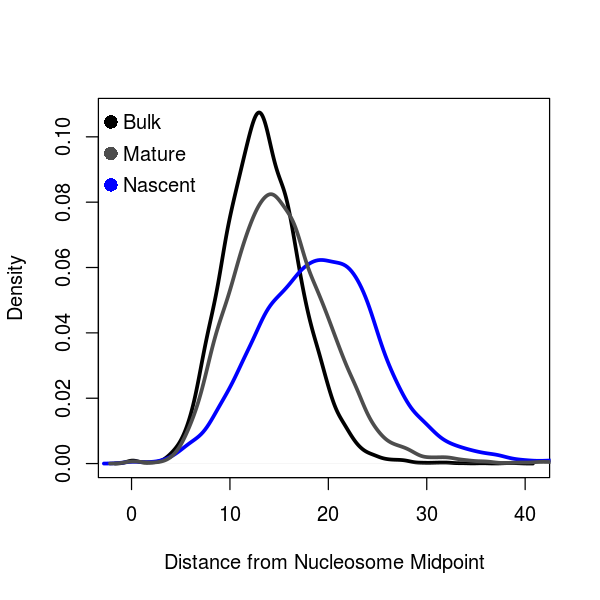

In [6]:
options(repr.plot.width=5, repr.plot.height=5)

#cl <- brewer.pal(12, "Paired")
plot(density(cn.df$mid_dist_e), col="black", xlab="Distance from Nucleosome Midpoint", lwd="3", main = ' ')
lines(density(cn.df$mid_dist_c), col='#0000ff', lwd="3")
lines(density(cn.df$mid_dist_d), col='#4d4d4d', lwd="3")
legend("topleft", col=c("black", '#4d4d4d', '#0000ff'), c("Bulk", "Mature", "Nascent"),pch=c(16,16), pt.cex=1.5,cex=1, 
       bty = "n", y.intersp=2, x.intersp=1)

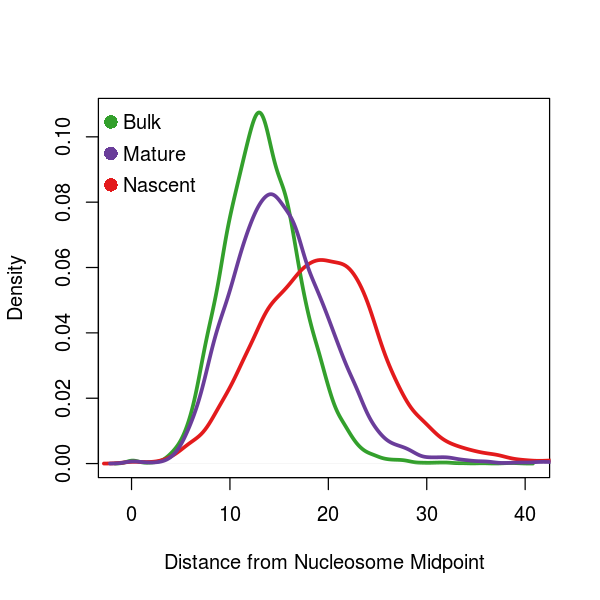

In [12]:
options(repr.plot.width=5, repr.plot.height=5)

cl <- brewer.pal(12, "Paired")
plot(density(cn.df$mid_dist_e), col=cl[4], main=" ",xlab="Distance from Nucleosome Midpoint",lwd="3")
lines(density(cn.df$mid_dist_c), col=cl[6], lwd="3")
lines(density(cn.df$mid_dist_d), col=cl[10], lwd="3")
legend('topleft', col=c(cl[4], cl[10],cl[6]), c("Bulk", "Mature","Nascent"),pch=c(16,16),
        pt.cex=1.5,cex=1, 
       bty = "n", y.intersp=2, x.intersp=1)

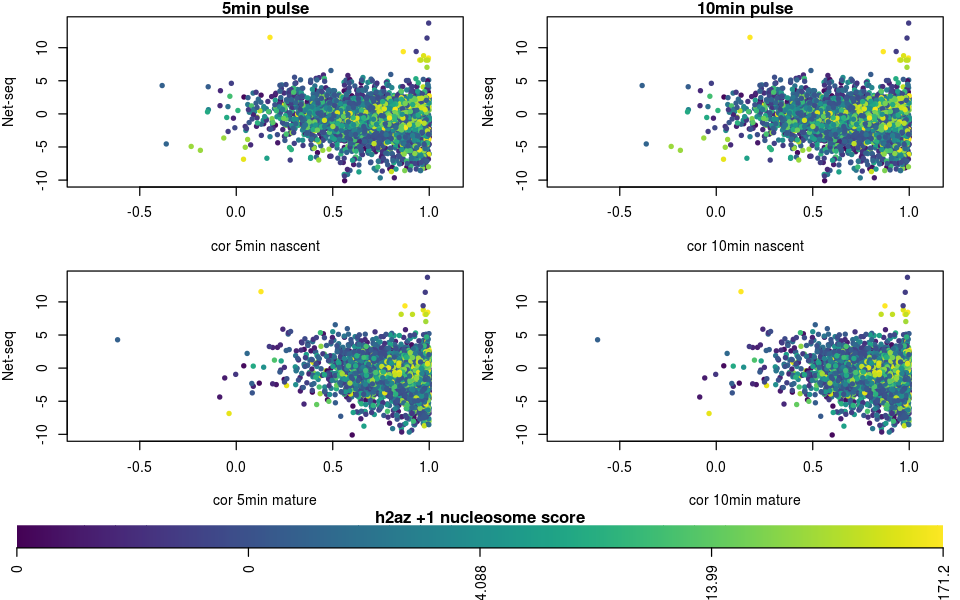

In [14]:
options(repr.plot.width=8, repr.plot.height=5) #, then use par(mfrow) to adjust number of rows and col for plots

layout(matrix(c(1,2,3,4,5,5), 3, 2, byrow = TRUE),
      widths=c(8,8), heights=c(5,5,1.8)) #widths= a vector of values for the widths of columns
#heights= a vector of values for the heights of rows.

par(mar=c(4,4,1,1), #bottom, left, top, and right.
   cex=0.7)

variable<- cn.df$h2az_1_score
y <- log2(cn.df$NET_seq)
x5n <- cn.df$EdU10_0_bulk
x10n <- cn.df$EdU10_0_bulk

x5 <- cn.df$EdU10_30_bulk
x10 <- cn.df$EdU10_30_bulk

n = 6664
sst <- summary(variable)

x_lim = c(-0.8,1.1)
y_lab ="Net-seq"
x10n_lab= 'cor 10min nascent'
x5n_lab= 'cor 5min nascent'

x10_lab= 'cor 10min mature'
x5_lab= 'cor 5min mature'

lbl="h2az +1 nucleosome score"

#color ramp with viridis package
cg <- viridis(6664, alpha = 1, begin = 0, end = 1, option = "D")

#in plot command -- note the double order
plot(x5n, y,col=cg[order(order(variable))], ylab= y_lab, xlab = x5n_lab, xlim = x_lim, pch=20, main="5min pulse")

plot(x10n,y,col=cg[order(order(variable))], ylab= y_lab, xlab = x10n_lab, xlim = x_lim, pch=20, main="10min pulse")

plot(x5, y,col=cg[order(order(variable))],  ylab= y_lab, xlab = x5_lab, xlim = x_lim, pch=20)

plot(x10,y,col=cg[order(order(variable))],  ylab= y_lab, xlab = x10_lab, xlim = x_lim, pch=20)

par(mar=c(3.1,1,1,1),#bottom, left, top, and right.
   cex=0.7)
image(1:n, 1, as.matrix(1:n), col = viridis(n, option = "D"),xlab='',ylab = "", xaxt = "n", 
      yaxt = "n", bty = "n", main = lbl)
axis(1, at=seq(1,n,length.out=5 ), labels=c(sst[1],sst[2],sst[3], sst[5], sst[6]) , las= 2 )

### my conclusion from this is that h2az is highly occupied at genes with higher correlation but does not seem to correlate with transcription. 

[1] 1668

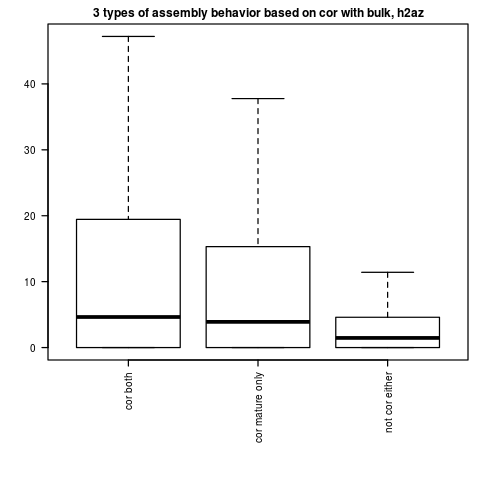

In [93]:
#dtermining 3 groups of genes with different assembly dynamics. 
nas = 3
mat=4
#1) genes with correlations in mature but not nascent:
# taking the number in the 3rd Quartile (75% observations are below this quantity(approx)) mature
cn_cor_mature <- cn.df[which(cn.df[,mat] > summary(cn.df[,mat])[5]),]

#taking the number in the 1st Quartile (25% observations are below this quantity(approx)) nascent 
cn_cor_mature_not_nascent <- cn_cor_mature[which(cn_cor_mature[,nas] < summary(cn_cor_mature[,nas])[2]),]

#2) genes with no correlations in neither of the samples. 
# taking the number in the 1st Quartile (25% observations are below this quantity(approx))
cn_nocor_mature <- cn.df[which(cn.df[,mat] < summary(cn.df[,mat])[2]),]

#taking the number in the 1st Quartile (25% observations are below this quantity(approx))
cn_nocor <- cn_nocor_mature[which(cn_nocor_mature[,nas] < summary(cn_nocor_mature[,nas])[2]),]

#3) genes with correlations on all samples. 
# taking the number in the 3rd Quartile (75% observations are below this quantity(approx))
cn_cor_mature <- cn.df[which(cn.df[,mat] > summary(cn.df[,mat])[5]),]

# taking the number in the 1st Quartile (25% observations are below this quantity(approx))
cn_cor_mature_n_nascent <- cn_cor_mature[which(cn_cor_mature[,nas] > summary(cn_cor_mature[,nas])[5]),]

clom='h2az_1_score'
options(repr.plot.width=4, repr.plot.height=4)
par(#mfrow=c(1,3),
    mar=c(10,4,2,1),
   cex=0.5)
boxplot((cn_cor_mature_n_nascent[,clom]),(cn_cor_mature_not_nascent[,clom]),(cn_nocor[,clom]),las=2,outline=FALSE, 
        main="3 types of assembly behavior based on cor with bulk, h2az", names=c("cor both", "cor mature only", 
                                                                                     "not cor either")) 

nrow(cn_cor_mature)

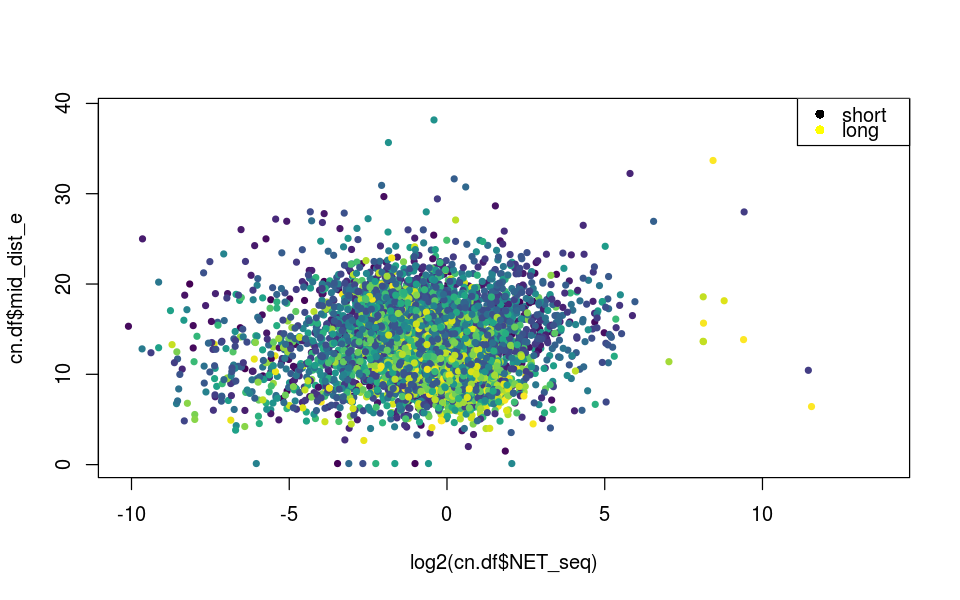

In [17]:
#color ramp with viridis package
variable<- cn.df$h2az_1_score

cg <- viridis(6664, alpha = 1, begin = 0, end = 1, option = "D")
plot(log2(cn.df$NET_seq), cn.df$mid_dist_e,col=cg[order(order(variable))], pch=20)
legend('topright', pch=c(16,16), col=c(1.5,6687), c("short", "long"), 
       bty="o", cex=1, box.col='black')

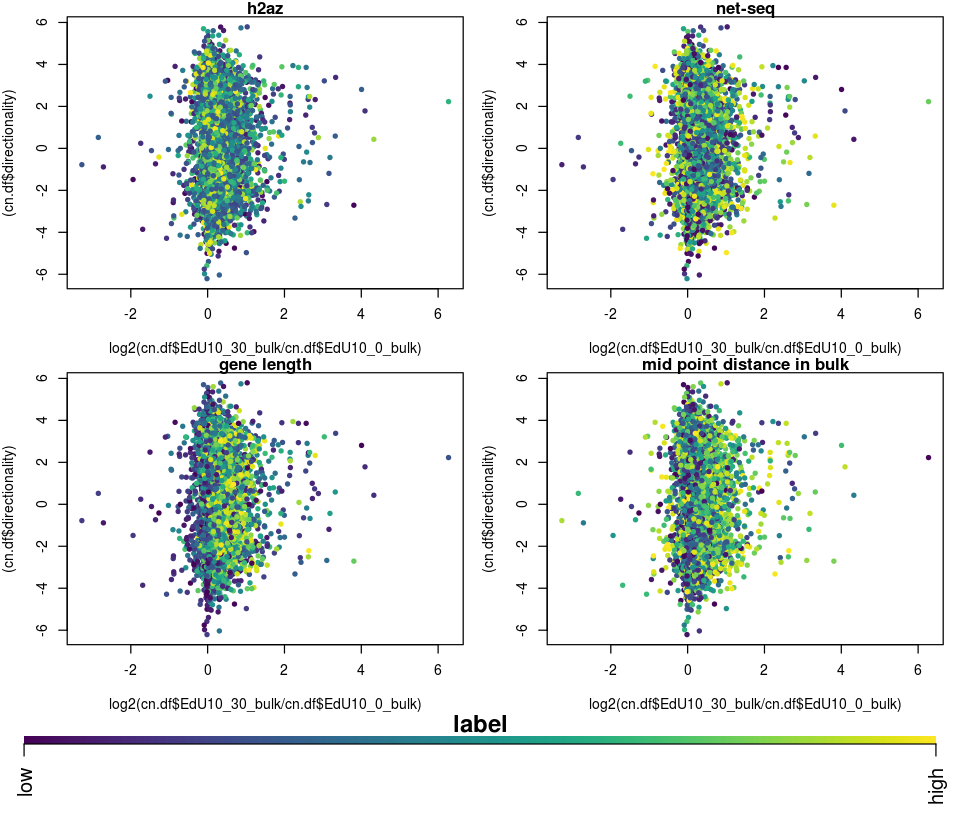

In [60]:
options(repr.plot.width=8, repr.plot.height=7) #, then use par(mfrow) to adjust number of rows and col for plots

layout(matrix(c(1,2,3,4,5,5), 3, 2, byrow = TRUE),
      widths=c(8,8), heights=c(5,5,1.8)) #widths= a vector of values for the widths of columns
#heights= a vector of values for the heights of rows.

par(mar=c(4,4,1,1), #bottom, left, top, and right.
   cex=0.7)

#color ramp with viridis package
cg <- viridis(6664, alpha = 1, begin = 0, end = 1, option = "D")

variable<- cn.df$h2az_1_score
clom='h2az'

plot( log2(cn.df$EdU10_30_bulk/cn.df$EdU10_0_bulk),(cn.df$directionality),pch=20,
     main=clom, col=cg[order(order(variable))])

#color ramp with viridis package
variable<- cn.df$NET_seq
clom='net-seq'

plot( log2(cn.df$EdU10_30_bulk/cn.df$EdU10_0_bulk),(cn.df$directionality),pch=20,
       main=clom, , col=cg[order(order(variable))])

#color ramp with viridis package
variable<- cn.df$length
clom='gene length'

plot( log2(cn.df$EdU10_30_bulk/cn.df$EdU10_0_bulk),(cn.df$directionality),pch=20,
       main=clom, , col=cg[order(order(variable))])

#color ramp with viridis package
variable<- cn.df$mid_dist_e
clom='mid point distance in bulk'

plot( log2(cn.df$EdU10_30_bulk/cn.df$EdU10_0_bulk),(cn.df$directionality),pch=20,
       main=clom, , col=cg[order(order(variable))])

n = 6664
lbl= 'label'

par(mar=c(4,1,1,1),#bottom, left, top, and right.
   cex=1)
image(1:n, 1, as.matrix(1:n), col = viridis(n, option = "D"),xlab='',ylab = "", xaxt = "n", 
      yaxt = "n", bty = "n", main = lbl)
axis(1, at=seq(1,n,length.out=2 ), labels=c("low", "high") , las= 2 )



In [62]:
nrow(cn.df)

[1] 6664

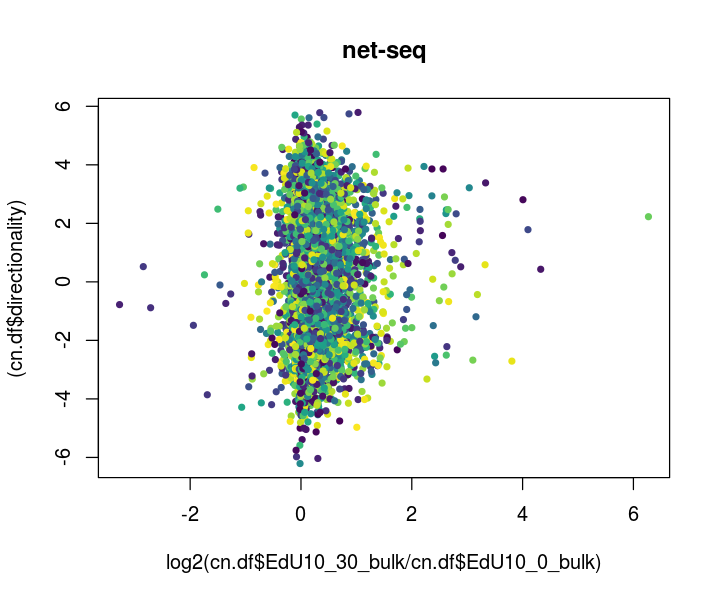

In [65]:
options(repr.plot.width=6, repr.plot.height=5) #, then use par(mfrow) to adjust number of rows and col for plots

#color ramp with viridis package
cg <- viridis(6664, alpha = 1, begin = 0, end = 1, option = "D")

#color ramp with viridis package
variable<- cn.df$NET_seq

clom='net-seq'

plot( log2(cn.df$EdU10_30_bulk/cn.df$EdU10_0_bulk),(cn.df$directionality),pch=20,
       main=clom, , col=cg[order(order(variable))])

In [51]:
pos <- cn.df[which(cn.df$strand == '+'),]

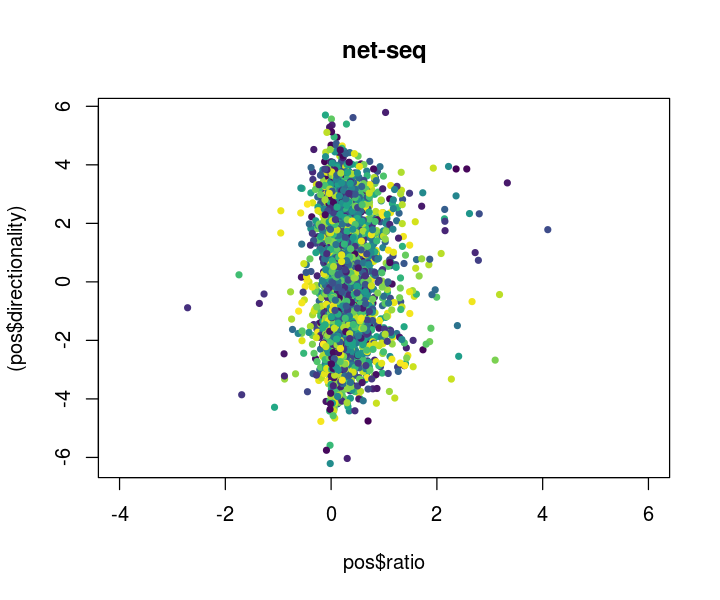

In [68]:
options(repr.plot.width=6, repr.plot.height=5) #, then use par(mfrow) to adjust number of rows and col for plots

#color ramp with viridis package
cg <- viridis(nrow(pos), alpha = 1, begin = 0, end = 1, option = "D")

#color ramp with viridis package
variable<- pos$NET_seq

clom='net-seq'

plot( pos$ratio,(pos$directionality),pch=20, xlim=c(-4,6),
       main=clom, , col=cg[order(order(variable))])


In [55]:
neg <- cn.df[which(cn.df$strand == '-'),]

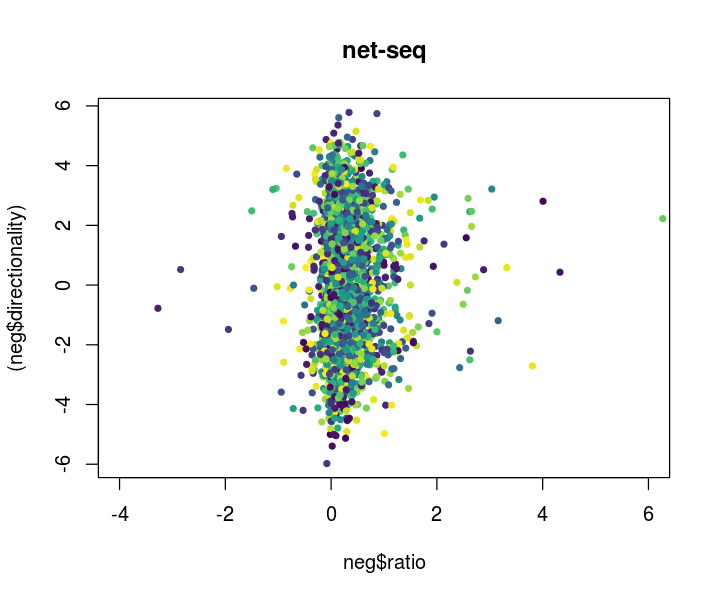

In [69]:
options(repr.plot.width=6, repr.plot.height=5) #, then use par(mfrow) to adjust number of rows and col for plots

cg <- viridis(nrow(neg), alpha = 1, begin = 0, end = 1, option = "D")

#color ramp with viridis package
variable<- neg$NET_seq

clom='net-seq'

plot( neg$ratio,(neg$directionality),pch=20, xlim=c(-4,6),
       main=clom, , col=cg[order(order(variable))])


Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”

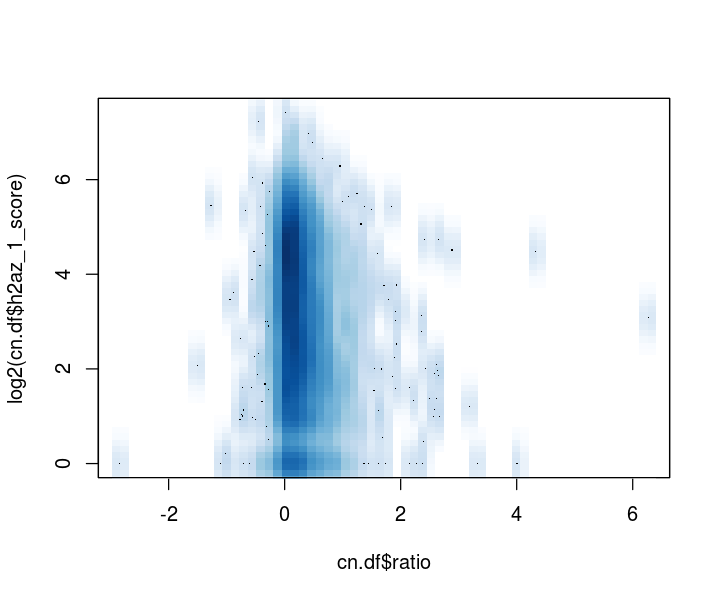

In [82]:
options(repr.plot.width=6, repr.plot.height=5) #, then use par(mfrow) to adjust number of rows and col for plots

smoothScatter(cn.df$ratio, log2(cn.df$h2az_1_score), nbin = 64)

In [8]:
for(i in 1:nrow(cn.df)){
    cn.df$ratio[i] <- log2(cn.df$EdU10_30_bulk[i]/cn.df$EdU10_0_bulk[i])
}

In [110]:
summary(cn.df[,'mid_ratio'])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-3.1200 -0.5501 -0.3221 -0.3319 -0.1049  2.2600 

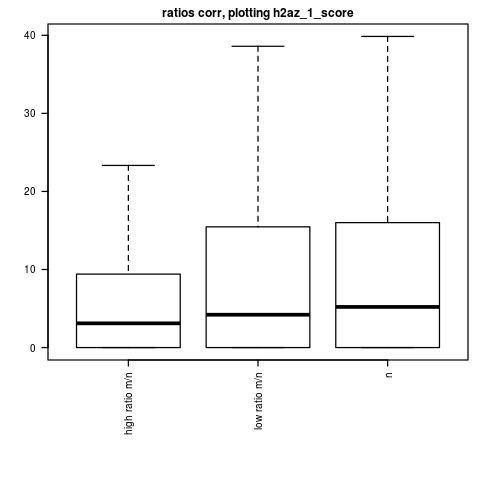

In [70]:
#determining 3 groups of genes with different assembly dynamics. 

h <- cn.df[which(cn.df[,'ratio'] > summary(cn.df[,'ratio'])[5]),]

l <- cn.df[which(cn.df[,'ratio'] < summary(cn.df[,'ratio'])[2]),]

n <- cn.df[which(cn.df[,'ratio'] > summary(cn.df[,'ratio'])[2] & cn.df[,'ratio'] < summary(cn.df[,'ratio'])[5]),]

clom='h2az_1_score'
options(repr.plot.width=4, repr.plot.height=4)
par(#mfrow=c(1,3),
    mar=c(10,4,2,1),
   cex=0.5)
boxplot((h[,clom]),(l[,clom]),(ns[,clom]),las=2,outline=FALSE, 
        main=paste("ratios corr, plotting",clom,sep=' '), 
        names=c("high ratio m/n", "low ratio m/n", "n")) 


In [22]:
head(cn.df)

EdU5_0_bulk,EdU5_30_bulk,EdU10_0_bulk,EdU10_30_bulk,inputs5_0_30,chr,gene,length,peaks,depth_a,⋯,mid_dist_e,strand,start,end,mRNA,NET_seq,h2az_1_score,directionality,ratio,mid_ratio
0.9135431,0.8273183,0.8876251,0.8155849,0.9971008,chrI,YAL069W,315,2,448,⋯,9.540117,+,334,649,0.000000000,0.000000000,16.958007,4.1085245,-0.12211555,-0.07532292
0.9781685,0.9993220,0.9861984,0.9942133,0.9961717,chrI,YAL068W-A,255,2,358,⋯,5.547945,+,537,792,0.003921569,0.003921569,17.861484,2.8073549,0.01167761,-0.60654936
0.8143767,0.9263432,0.4484318,0.8916972,0.9808242,chrI,YAL068C,363,3,355,⋯,13.027397,-,1806,2169,0.011019284,0.022038567,22.313863,0.7776076,0.99166541,-1.06420963
0.9934882,0.9861784,0.9784249,0.9928258,0.9942989,chrI,YAL067W-A,228,2,230,⋯,9.825832,+,2479,2707,0.004385965,0.017543860,0.000000,0.2895066,0.02107955,0.71109071
0.7224885,0.8319213,0.4346318,0.8342221,0.9330314,chrI,YAL067C,1782,14,1926,⋯,16.164384,-,7234,9016,0.020202020,0.047699214,4.575806,-2.7789731,0.94063786,0.15375568
0.8092933,0.8946042,0.6975887,0.5412692,0.9049782,chrI,YAL066W,309,3,445,⋯,15.761252,+,10090,10399,0.000000000,0.006472492,1.000000,2.2223924,-0.36603042,-0.08953853


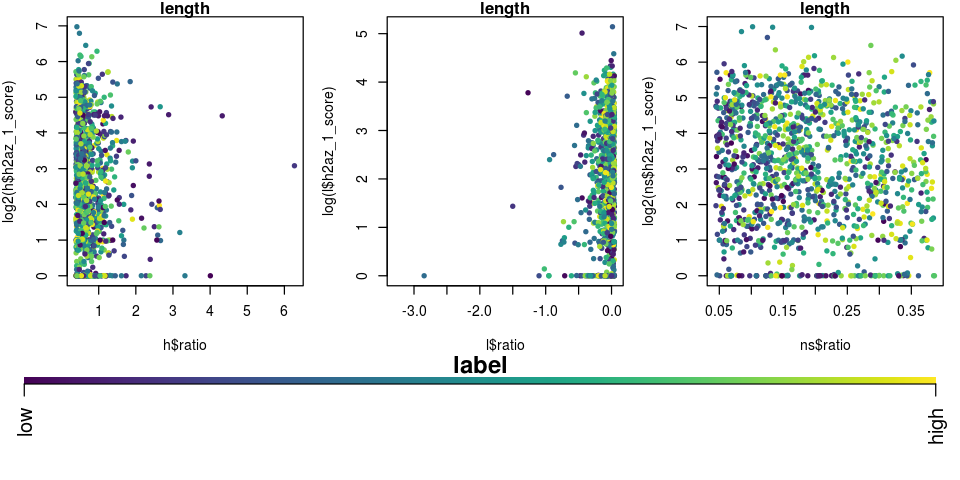

In [85]:
options(repr.plot.width=8, repr.plot.height=4) #, then use par(mfrow) to adjust number of rows and col for plots

layout(matrix(c(1,2,3,4,4,4), 2, 3, byrow = TRUE),
      widths=c(8,8,8), heights=c(5,1.8)) #widths= a vector of values for the widths of columns
#heights= a vector of values for the heights of rows.

par(mar=c(4,4,1,1), #bottom, left, top, and right.
   cex=0.7)

#color ramp with viridis package
cg <- viridis(nrow(h), alpha = 1, begin = 0, end = 1, option = "D")

clom='length'

variablel<- l$length
plot( l$ratio,log(l$h2az_1_score),pch=20,
     main=clom, col=cg[order(order(variablel))])

variablens<- ns$length
plot( ns$ratio,log2(ns$h2az_1_score),pch=20,
     main=clom, col=cg[order(order(variablens))])

variableh<- h$length
plot( h$ratio,log2(h$h2az_1_score),pch=20,
     main=clom, col=cg[order(order(variableh))])

n = nrow(h)
lbl= 'label'

par(mar=c(4,1,1,1),#bottom, left, top, and right.
   cex=1)
image(1:n, 1, as.matrix(1:n), col = viridis(n, option = "D"),xlab='',ylab = "", xaxt = "n", 
      yaxt = "n", bty = "n", main = lbl)
axis(1, at=seq(1,n,length.out=2 ), labels=c("low", "high") , las= 2 )



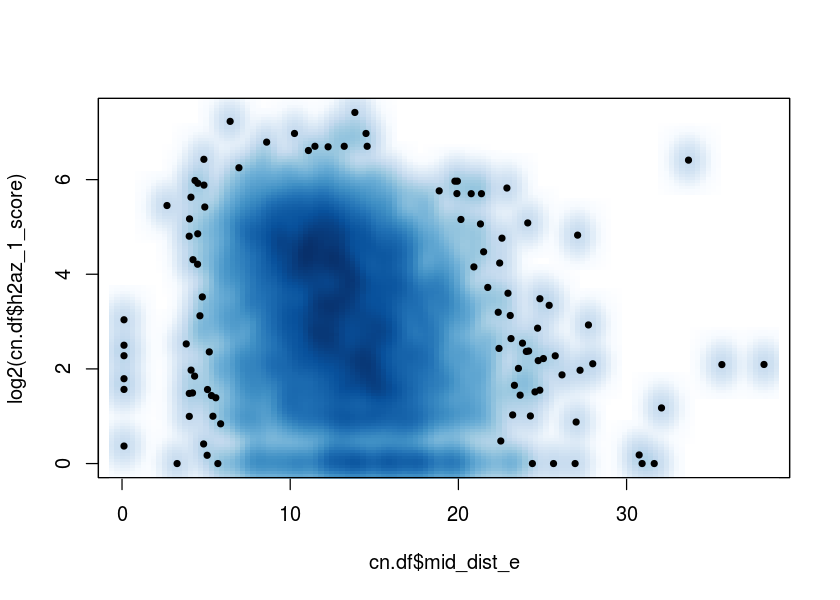

In [92]:
options(repr.plot.width=7, repr.plot.height=5) #, then use par(mfrow) to adjust number of rows and col for plots

smoothScatter(cn.df$mid_dist_e, log2(cn.df$h2az_1_score), pch=20)

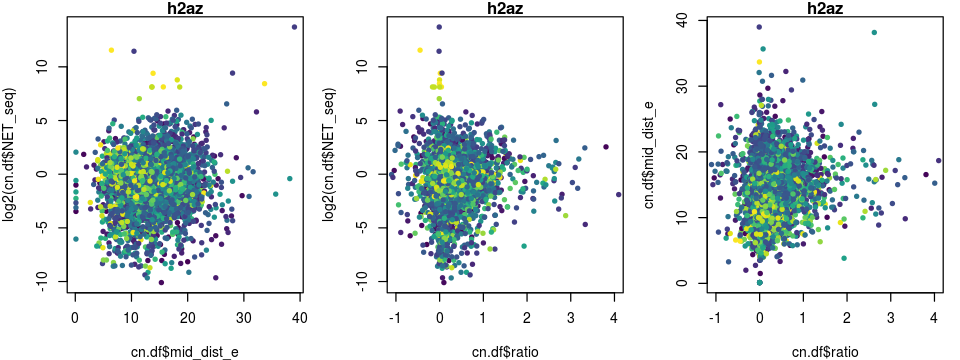

In [103]:
options(repr.plot.width=8, repr.plot.height=3) #, then use par(mfrow) to adjust number of rows and col for plots

cg <- viridis(nrow(cn.df), alpha = 1, begin = 0, end = 1, option = "D")

par(mfrow = c(1,3),
   mar=c(4,4,1,1), #bottom, left, top, and right.
   cex=0.7)

#color ramp with viridis package
variable<- cn.df$h2az_1_score

clom='h2az'

plot( cn.df$mid_dist_e,log2(cn.df$NET_seq),pch=20, 
       main=clom, , col=cg[order(order(variable))])

clom='h2az'

plot( cn.df$ratio,log2(cn.df$NET_seq),pch=20, xlim=c(-1,4),
       main=clom, , col=cg[order(order(variable))])

clom='h2az'

plot( cn.df$ratio,cn.df$mid_dist_e,pch=20, xlim=c(-1,4),
       main=clom, , col=cg[order(order(variable))])


In [104]:
for(i in 1:nrow(cn.df)){
    cn.df$mid_ratio[i] <- log2(cn.df$mid_dist_d[i]/cn.df$mid_dist_c[i])
}

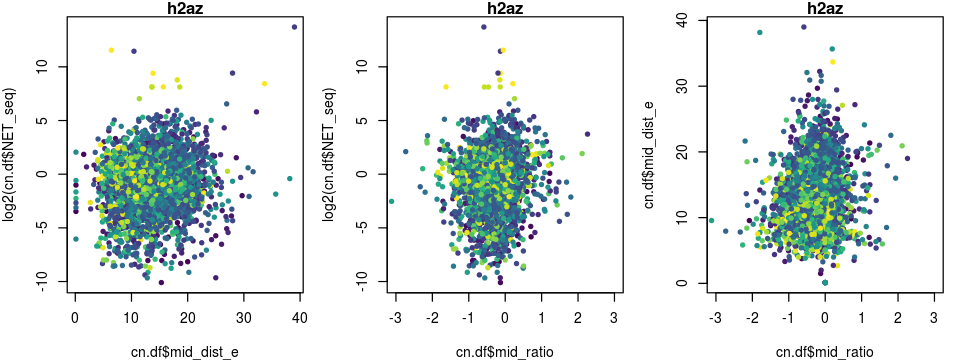

In [108]:
options(repr.plot.width=8, repr.plot.height=3) #, then use par(mfrow) to adjust number of rows and col for plots

cg <- viridis(nrow(cn.df), alpha = 1, begin = 0, end = 1, option = "D")

par(mfrow = c(1,3),
   mar=c(4,4,1,1), #bottom, left, top, and right.
   cex=0.7)

#color ramp with viridis package
variable<- cn.df$h2az_1_score

clom='h2az'

plot( cn.df$mid_dist_e,log2(cn.df$NET_seq),pch=20, 
       main=clom, , col=cg[order(order(variable))])

clom='h2az'

plot( cn.df$mid_ratio,log2(cn.df$NET_seq),pch=20, xlim=c(-3,3),
       main=clom, , col=cg[order(order(variable))])

clom='h2az'

plot( cn.df$mid_ratio,cn.df$mid_dist_e,pch=20, xlim=c(-3,3),
       main=clom, , col=cg[order(order(variable))])


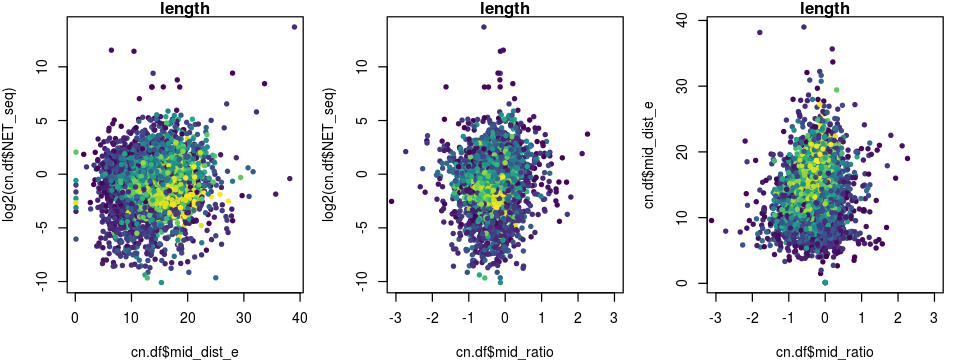

In [117]:
options(repr.plot.width=8, repr.plot.height=3) #, then use par(mfrow) to adjust number of rows and col for plots

cg <- viridis(nrow(cn.df), alpha = 1, begin = 0, end = 1, option = "D")

par(mfrow = c(1,3),
   mar=c(4,4,1,1), #bottom, left, top, and right.
   cex=0.7)

#color ramp with viridis package
variable<- cn.df$length

clom='length'

plot( cn.df$mid_dist_e,log2(cn.df$NET_seq),pch=20, 
       main=clom, , col=cg[order(order(variable))])


plot( cn.df$mid_ratio,log2(cn.df$NET_seq),pch=20, xlim=c(-3,3),
       main=clom, , col=cg[order(order(variable))])


plot( cn.df$mid_ratio,cn.df$mid_dist_e,pch=20, xlim=c(-3,3),
       main=clom, , col=cg[order(order(variable))])


In [27]:
qnorm(0.05, mean(cn.df$mid_ratio), sd(cn.df$mid_ratio))

[1] -0.9871004

In [28]:
for(i in 1:nrow(cn.df)){
    cn.df$cdepth_c[i] <- cn.df$depth_c[i]/cn.df$length[i]
    cn.df$cdepth_d[i] <- cn.df$depth_d[i]/cn.df$length[i]
    cn.df$cdepth_e[i] <- cn.df$depth_e[i]/cn.df$length[i]
}

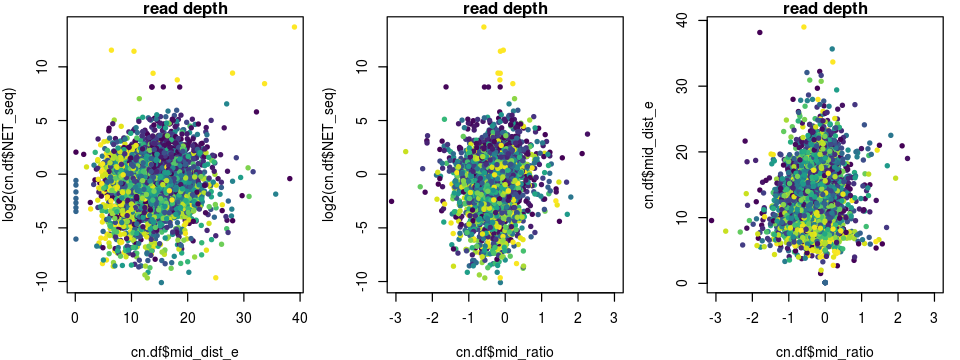

In [14]:
options(repr.plot.width=8, repr.plot.height=3) #, then use par(mfrow) to adjust number of rows and col for plots

cg <- viridis(nrow(cn.df), alpha = 1, begin = 0, end = 1, option = "D")

par(mfrow = c(1,3),
   mar=c(4,4,1,1), #bottom, left, top, and right.
   cex=0.7)

#color ramp with viridis package
variable<- cn.df$cdepth_e

clom='read depth'

plot( cn.df$mid_dist_e,log2(cn.df$NET_seq),pch=20, 
       main=clom, , col=cg[order(order(variable))])


plot( cn.df$mid_ratio,log2(cn.df$NET_seq),pch=20, xlim=c(-3,3),
       main=clom, , col=cg[order(order(variable))])


plot( cn.df$mid_ratio,cn.df$mid_dist_e,pch=20, xlim=c(-3,3),
       main=clom, , col=cg[order(order(variable))])


In [ ]:
#APRIL 13, 2017

In [5]:
head(cn.df) # the ratio in this data frame is log transformed

EdU5_0_bulk,EdU5_30_bulk,EdU10_0_bulk,EdU10_30_bulk,inputs5_0_30,chr,gene,length,peaks,depth_a,⋯,mid_dist_e,strand,start,end,mRNA,NET_seq,h2az_1_score,directionality,ratio,mid_ratio
0.9135431,0.8273183,0.8876251,0.8155849,0.9971008,chrI,YAL069W,315,2,448,⋯,9.540117,+,334,649,0.000000000,0.000000000,16.958007,4.1085245,-0.12211555,-0.07532292
0.9781685,0.9993220,0.9861984,0.9942133,0.9961717,chrI,YAL068W-A,255,2,358,⋯,5.547945,+,537,792,0.003921569,0.003921569,17.861484,2.8073549,0.01167761,-0.60654936
0.8143767,0.9263432,0.4484318,0.8916972,0.9808242,chrI,YAL068C,363,3,355,⋯,13.027397,-,1806,2169,0.011019284,0.022038567,22.313863,0.7776076,0.99166541,-1.06420963
0.9934882,0.9861784,0.9784249,0.9928258,0.9942989,chrI,YAL067W-A,228,2,230,⋯,9.825832,+,2479,2707,0.004385965,0.017543860,0.000000,0.2895066,0.02107955,0.71109071
0.7224885,0.8319213,0.4346318,0.8342221,0.9330314,chrI,YAL067C,1782,14,1926,⋯,16.164384,-,7234,9016,0.020202020,0.047699214,4.575806,-2.7789731,0.94063786,0.15375568
0.8092933,0.8946042,0.6975887,0.5412692,0.9049782,chrI,YAL066W,309,3,445,⋯,15.761252,+,10090,10399,0.000000000,0.006472492,1.000000,2.2223924,-0.36603042,-0.08953853


In [6]:
for(i in 1:nrow(cn.df)){
    cn.df$ratio[i] <- (cn.df$EdU10_30_bulk[i]/cn.df$EdU10_0_bulk[i])
}

In [7]:
top10p <- subset(cn.df, ratio >= quantile(ratio, 0.90))

In [8]:
bottom10p <- subset(cn.df, ratio <= quantile(ratio, 0.10))

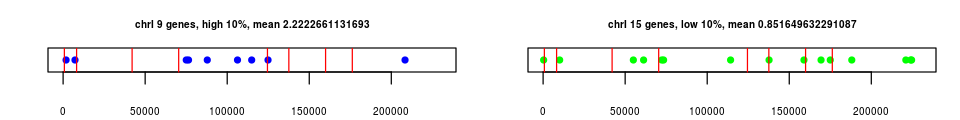

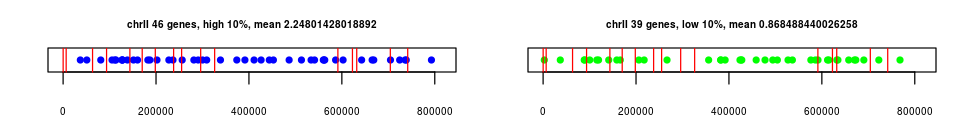

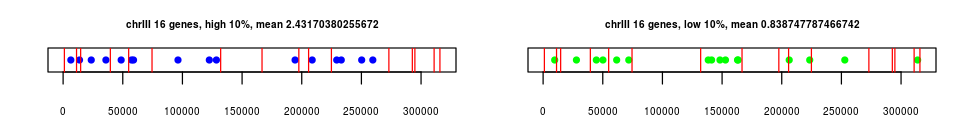

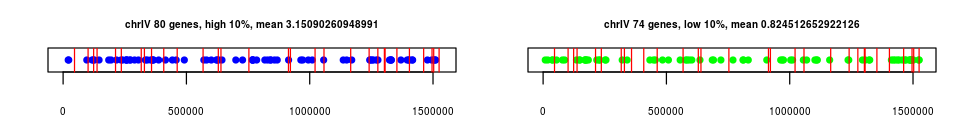

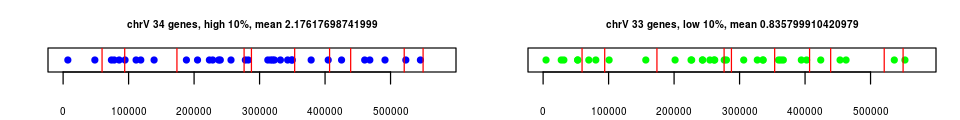

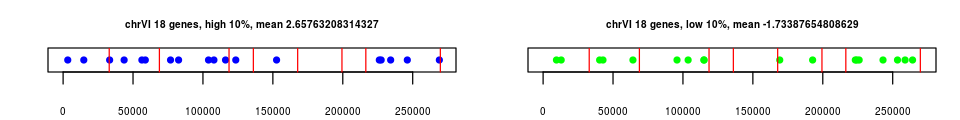

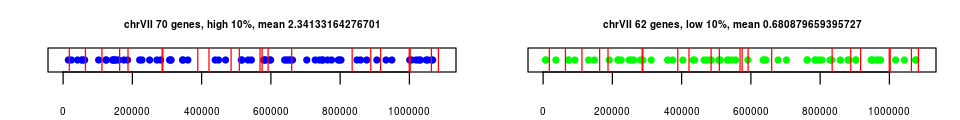

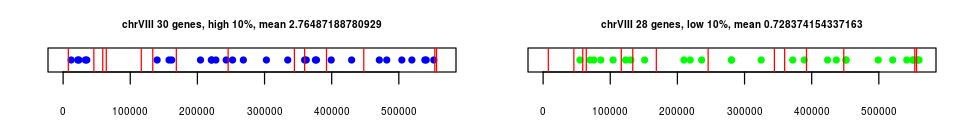

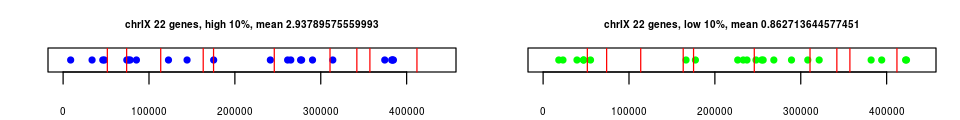

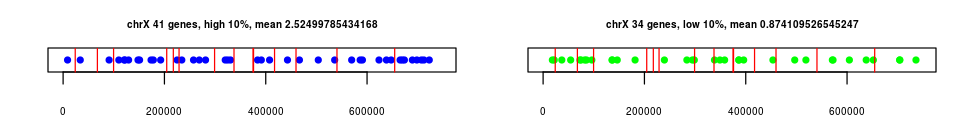

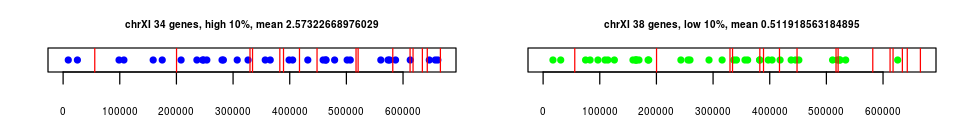

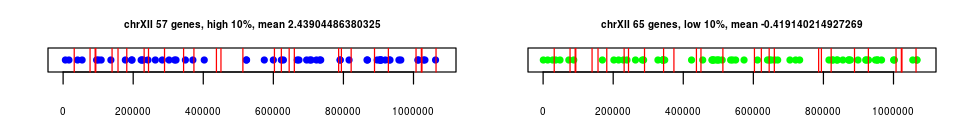

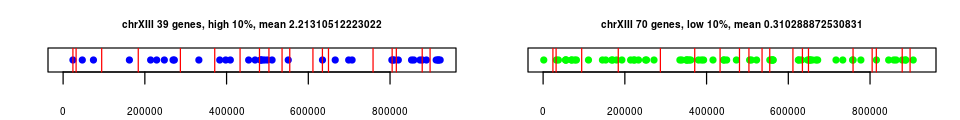

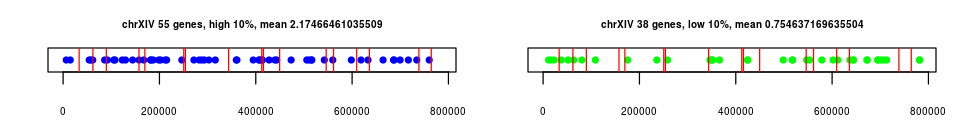

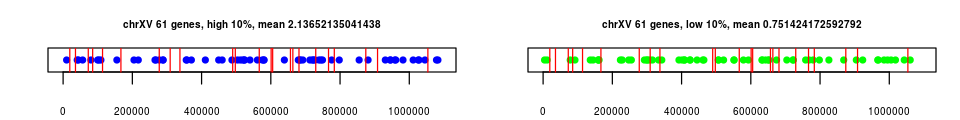

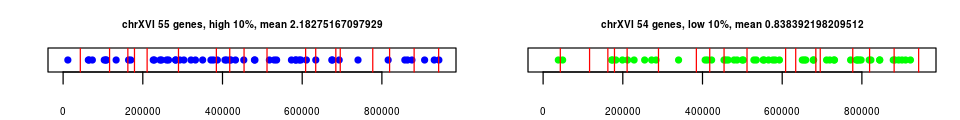

In [21]:
options(repr.plot.width=8, repr.plot.height=1)
library(viridis) #The viridis color palettes
library(RColorBrewer)

options(scipen=999) #disabling scientific notation 1= "230218",
chr_coordinates.df <- data.frame(chr=(c("chrI", "chrII", "chrIII", "chrIV", "chrV", "chrVI", "chrVII", "chrVIII", "chrIX", "chrX", "chrXI", "chrXII",
                                        "chrXIII", "chrXIV", "chrXV","chrXVI")),
                                 end=as.numeric(c("230218","813184", "316620", "1531933", "576874", "270161", "1090940", "562643", "439888", "745751", "666816", "1078177", "924431", "784333", "1091291", "948066")), stringsAsFactors=FALSE)

for (c in 1:nrow(chr_coordinates.df)){
	chr = chr_coordinates.df[c,"chr"]
	
  #chromosome lentgh (start and end) for genomic ranges
	new_start= 1
	new_end= chr_coordinates.df$end[c] 
    
       
    par(mfrow=c(1,2),
         mar=c(2,2,2,1),
        cex.axis=0.5, 
       cex.main=0.5)

    o <- oris[which(oris$chr == chr),]
    
    ssc<- top10p[which(top10p$chr == chr),]
    y <- rep(0, length(ssc$start) )
       
    plot(ssc$start,y, xlim=c(1, new_end), col= "blue",pch=20, yaxt='n',
         main= paste(chr, length(ssc$start),"genes, high 10%, mean", mean(ssc$ratio),sep=' '))
         abline(v=o$pos, col= "red")
    
    sscb<- bottom10p[which(bottom10p$chr == chr),]
    yb <- rep(0, length(sscb$start) )
   
    plot(sscb$start,yb, xlim=c(1, new_end), col= "green",pch=20, yaxt='n', 
         main= paste(chr, length(sscb$start),"genes, low 10%, mean", mean(sscb$ratio), sep=' '))
    abline(v=o$pos, col= "red")
    
  }





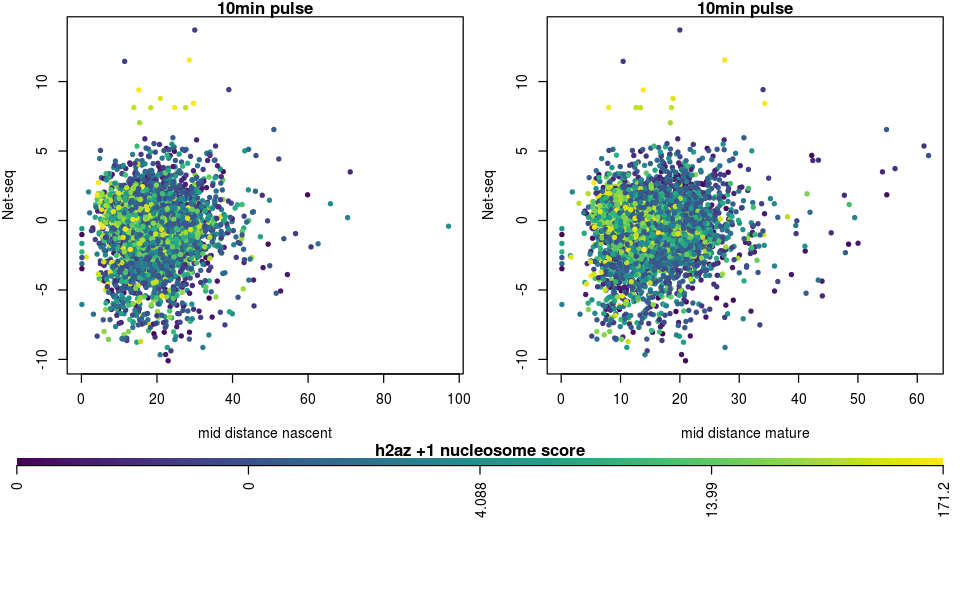

In [38]:
options(repr.plot.width=8, repr.plot.height=5) #, then use par(mfrow) to adjust number of rows and col for plots

layout(matrix(c(1,2,3,3), 2, 2, byrow = TRUE),
      widths=c(8,8), heights=c(5,1.8)) #widths= a vector of values for the widths of columns
#heights= a vector of values for the heights of rows.

par(mar=c(4,4,1,1), #bottom, left, top, and right.
   cex=0.7)

variable<- cn.df$h2az_1_score
y <- log2(cn.df$NET_seq)
x5n <- cn.df$mid_dist_c
x10n <- cn.df$mid_dist_d

n = 6664
sst <- summary(variable)

#x_lim = c(-0.8,1.1)
y_lab ="Net-seq"
x5n_lab= 'mid distance nascent'
x10n_lab= 'mid distance mature'


lbl="h2az +1 nucleosome score"

#color ramp with viridis package
cg <- viridis(nrow(cn.df), alpha = 1, begin = 0, end = 1, option = "D")

#in plot command -- note the double order
plot(x5n, y,col=cg[order(order(variable))], ylab= y_lab, xlab = x5n_lab, pch=20, main="10min pulse")#xlim = x_lim

plot(x10n,y,col=cg[order(order(variable))], ylab= y_lab, xlab = x10n_lab, pch=20, main="10min pulse")#xlim = x_lim

par(mar=c(8,1,1,1),#bottom, left, top, and right.
   cex=0.7)
image(1:n, 1, as.matrix(1:n), col = viridis(n, option = "D"),xlab='',ylab = "", xaxt = "n", 
      yaxt = "n", bty = "n", main = lbl)
axis(1, at=seq(1,n,length.out=5 ), labels=c(sst[1],sst[2],sst[3], sst[5], sst[6]) , las= 2 )

### my conclusion from this is that h2az is highly occupied at genes with higher correlation but does not seem to correlate with transcription. 

In [13]:
mid <- c(230218/2,813184/2, 316620/2, 1531933/2, 576874/2, 270161/2, 1090940/2,
         562643/2, 439888/2, 745751/2, 666816/2, 1078177/2, 924431/2, 784333/2, 1091291/2, 948066/2)

In [14]:

library(viridis) #The viridis color palettes
library(RColorBrewer)

options(scipen=999) #disabling scientific notation 1= "230218",
chr_coordinates.df <- data.frame(chr=(c("chrI", "chrII", "chrIII", "chrIV", "chrV", "chrVI", "chrVII", "chrVIII", "chrIX", "chrX", "chrXI", "chrXII",
                                        "chrXIII", "chrXIV", "chrXV","chrXVI")),
                                 end=as.numeric(c("230218","813184", "316620", "1531933", "576874", "270161", "1090940", 
                                                  "562643", "439888", "745751", "666816", "1078177", "924431", "784333", "1091291", "948066")),
                                
                                 mid=mid,stringsAsFactors=FALSE)

In [22]:
1531933/2

[1] 765966.5

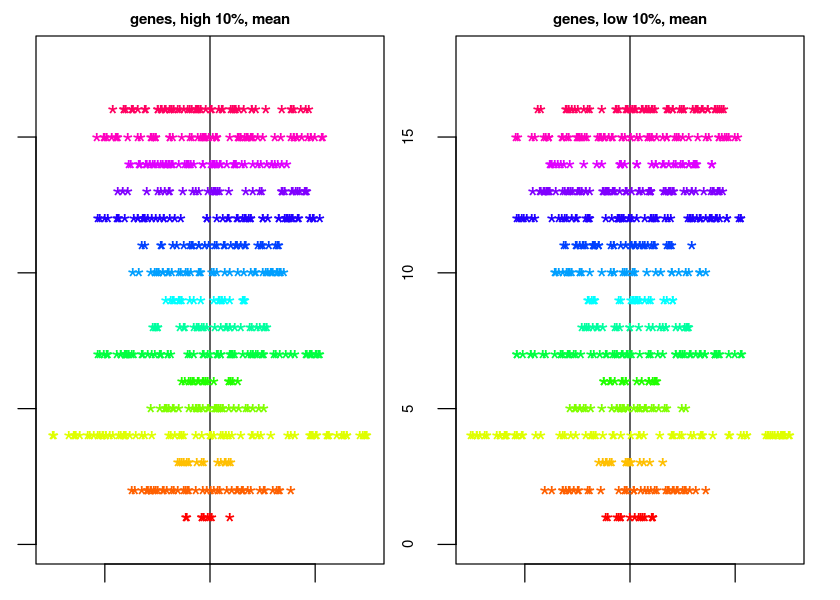

In [66]:
options(rep.plot.width=14, repr.plot.height=5)
cr <- rainbow(16)
     
    par(mfrow=c(1,2),
         mar=c(1,1,1,1),
        cex.axis=0.5, 
       cex.main=0.5, 
       cex=1.5)

plot(1,xlim=c(-765966.5, 765966.5),ylim=c(0,18), type="n", xlab="coordinate", ylab="Chromosome",
     main = "genes, high 10%, mean")
abline(v=0)
    
for (c in 1:16){
	chr = chr_coordinates.df[c,"chr"]
    new_mid <-  chr_coordinates.df[c,3]
    
    ssT<- top10p[which(top10p$chr == chr),]
    
    
    for(i in 1:nrow(ssT)){
       ssT$new_start[i] <- ssT$start[i]- new_mid    
  }
     y <- rep(c, length(ssT$new_start) )
    points(ssT$new_start, y, pch='*', col=cr[c])
}

plot(1,xlim=c(-765966.5, 765966.5),ylim=c(0,18), type="n", xlab="coordinate", ylab="Chromosome",
     main = "genes, low 10%, mean")
abline(v=0)

for (c in 1:16){
	chr = chr_coordinates.df[c,"chr"]
    new_mid <-  chr_coordinates.df[c,3]
    
    ssB<- bottom10p[which(bottom10p$chr == chr),]
    
    
    for(i in 1:nrow(ssB)){
       ssB$new_start[i] <- ssB$start[i]- new_mid    
  }
     y <- rep(c, length(ssB$new_start) )
    points(ssB$new_start, y, pch='*', col=cr[c])
}
